In [ ]:
#  Imports & style
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_context("notebook")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)


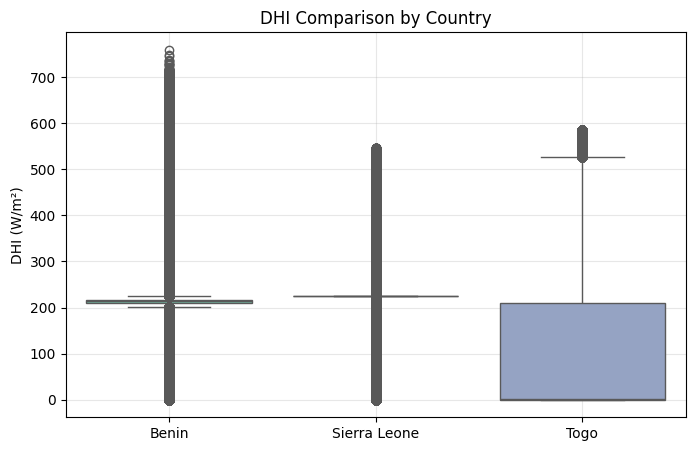

In [14]:

# Load cleaned CSVs (your actual names)
files = {
    "Benin": "../data/benin_clean.csv",
    "Sierra Leone": "../data/sierra_leone_clean.csv",
    "Togo": "../data/togo_clean.csv",
}

# Check file existence
for k, v in files.items():
    print(f"{k}: {'✅' if os.path.exists(v) else '❌'} {v}")

# Load CSVs
benin  = pd.read_csv(files["Benin"])
sierra = pd.read_csv(files["Sierra Leone"])
togo   = pd.read_csv(files["Togo"])

# Rebuild 'hour' column (if missing)
for df in (benin, sierra, togo):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df["hour"] = df["Timestamp"].dt.hour

# Add country column
benin["Country"]  = "Benin"
sierra["Country"] = "Sierra Leone"
togo["Country"]   = "Togo"

# Combine all datasets
df_all = pd.concat([benin, sierra, togo], ignore_index=True)
df_all.head()

Benin: ✅ ../data/benin_clean.csv
Sierra Leone: ✅ ../data/sierra_leone_clean.csv
Togo: ✅ ../data/togo_clean.csv


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,hour,Country
0,2021-08-09 00:01:00,474.2,345.7,213.4,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,0,Benin
1,2021-08-09 00:02:00,474.2,345.7,213.4,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,0,Benin
2,2021-08-09 00:03:00,474.2,345.7,213.4,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,0,Benin
3,2021-08-09 00:04:00,474.2,345.7,213.4,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,0,Benin
4,2021-08-09 00:05:00,474.2,345.7,213.4,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,0,Benin


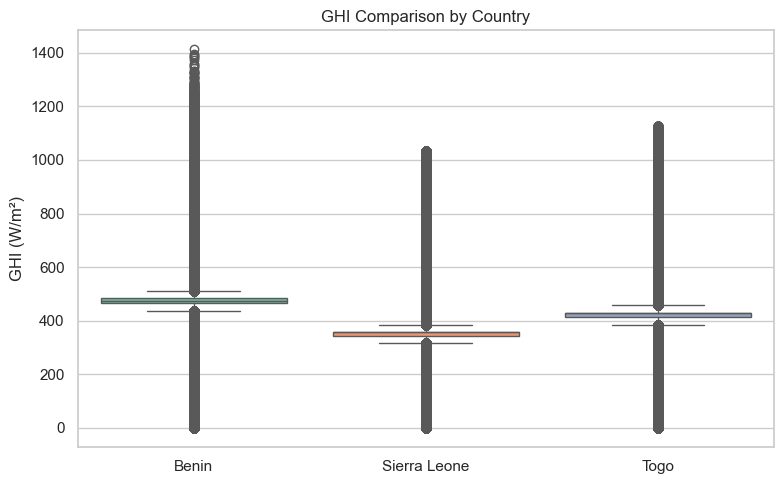

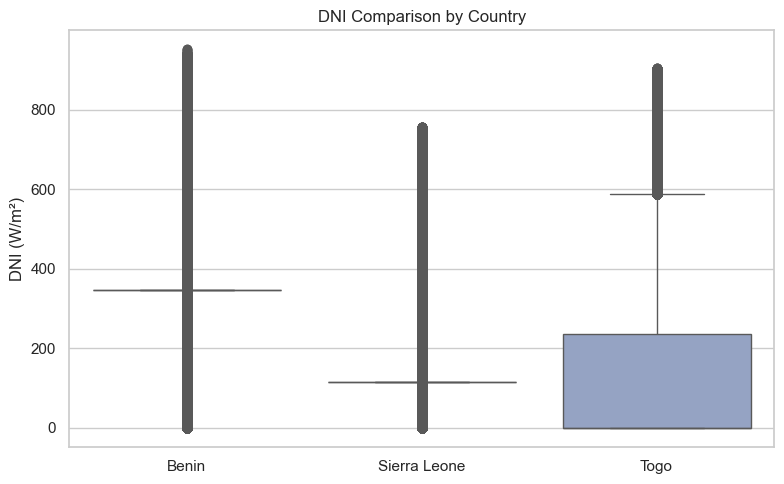

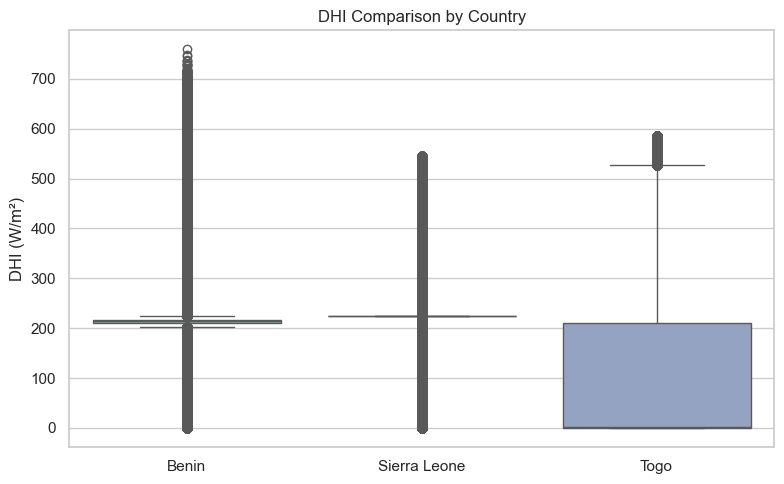

In [15]:
# Boxplots with hue to avoid seaborn deprecation warning
metrics = ["GHI", "DNI", "DHI"]

for metric in metrics:
    plt.figure()
    sns.boxplot(x="Country", y=metric, hue="Country", data=df_all, palette="Set2", legend=False)
    plt.title(f"{metric} Comparison by Country")
    plt.xlabel("")
    plt.ylabel(f"{metric} (W/m²)")
    plt.tight_layout()
    plt.show()


In [16]:
# — Summary table
summary = (
    df_all.groupby("Country")[["GHI", "DNI", "DHI"]]
    .agg(["mean", "median", "std"])
    .round(2)
)

summary


GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         475.49  474.2  228.39  348.97  345.7  193.44  222.22  213.4   
Sierra Leone  365.54  359.5  195.93  161.28  115.3  172.62  223.62  225.0   
Togo          437.43  430.3  223.43  147.28    0.0  246.98  112.43    1.4   

                      
                 std  
Country               
Benin         107.49  
Sierra Leone   96.85  
Togo          151.28

In [18]:
os.makedirs("../output", exist_ok=True)
summary.to_csv("../output/summary_stats_ghi_dni_dhi.csv")


In [19]:
#One-way ANOVA on GHI across countries
f_stat, p_val = stats.f_oneway(
    benin["GHI"].dropna(),
    sierra["GHI"].dropna(),
    togo["GHI"].dropna()
)
print(f"ANOVA (GHI): F = {f_stat:.3f}, p = {p_val:.6f}")
print("✅ Significant difference in mean GHI across countries." if p_val < 0.05
      else "ℹ️ No statistically significant difference detected.")

ANOVA (GHI): F = 34030.990, p = 0.000000
✅ Significant difference in mean GHI across countries.


In [20]:
# Non-parametric test if distributions are non-normal
h_stat, p_kw = stats.kruskal(
    benin["GHI"].dropna(),
    sierra["GHI"].dropna(),
    togo["GHI"].dropna()
)
print(f"Kruskal–Wallis (GHI): H = {h_stat:.3f}, p = {p_kw:.6f}")


Kruskal–Wallis (GHI): H = 199200.745, p = 0.000000


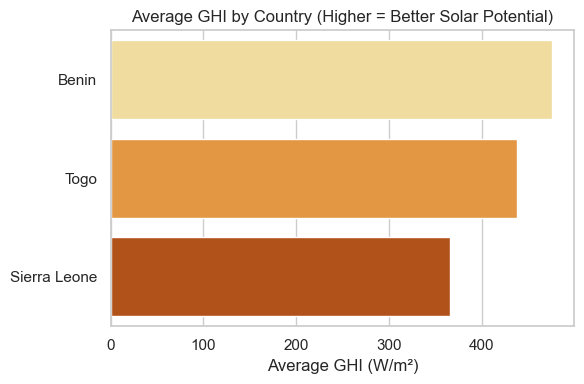

In [21]:
#Bar chart ranking by average GHI
avg_ghi = (
    df_all.groupby("Country")["GHI"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,4))
sns.barplot(x=avg_ghi.values, y=avg_ghi.index, palette="YlOrBr")
plt.title("Average GHI by Country (Higher = Better Solar Potential)")
plt.xlabel("Average GHI (W/m²)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Save (optional)
os.makedirs("../output", exist_ok=True)
avg_ghi.to_csv("../output/avg_ghi_by_country.csv")




Key Observations

[Country Benin] shows the highest median GHI and highest mean, indicating stronger solar potential overall.

[Country sierra_leon] has lower median GHI but tighter spread, suggesting more consistent irradiance (lower variability).

[Country Togo] exhibits greater variability (wider IQR/outliers), which may reflect seasonal or weather fluctuations.
